## Case Study
#### Understand the problem statement
1. Import relavent packages
2. Load the data
3. Data pre-processing and EDA
4. Create training and test splits
5. Define architecture RNN/LSTM/GRU
6. Compiling the model
7. Fit the model -  train the model on training dataset
8. Evaluation the model - loss value, accuracy
9. Making prediction - Unseen dataset 


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re   #Regex

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model

import warnings
warnings.filterwarnings('ignore')

In [5]:
#Importing the dataset 
df_train = pd.read_csv('/Users/pawankumarkc/Documents/vscode_workspace/MLAlgo/datasets/RNN/tweets_train.csv')
df_test = pd.read_csv('/Users/pawankumarkc/Documents/vscode_workspace/MLAlgo/datasets/RNN/tweets_test.csv')

In [6]:
df_train.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,clean_text,Sentiment
0,Romy 👑,Bolton - England,"Tables turn, bridges burn, you live and learn.",2009-06-15 09:00:39,525,896,3854,False,2020-09-19 15:19:32,['TheSocialDilemma'],Twitter for Android,False,TheSocialDilemma is an eye opener isn t it ple...,Neutral
1,TLynn Peterson,"Black Canyon City, Arizona",Acquired disability ♿ after an accident. Livin...,2013-05-29 00:17:46,5045,5374,48152,False,2020-09-13 00:31:46,['TheSocialDilemma'],Twitter for Android,False,TheSocialDilemma If we don t agree on what is ...,Positive
2,Rutger Kosters,Netherlands,Cloud Solution Architect @NetApp | VCDX #209 |...,2014-10-07 09:34:10,574,251,1070,False,2020-09-09 21:10:33,['TheSocialDilemma'],Twitter for Android,False,Watching TheSocialDilemma scary to see social ...,Negative
3,IDFWU🗯🇿🇼🇿🇦,"East London, South Africa","YOU HAVE OPTIONS, YOU CAN’T JUST TAKE WHAT LIF...",2012-08-22 11:09:06,706,618,1320,False,2020-09-11 04:33:08,NaN,Twitter for Android,False,You check your social media before you pee in ...,Positive
4,Treebel,NaN,NaN,2010-09-25 07:25:31,9,13,55,False,2020-09-17 16:27:38,['thesocialdilemma'],Twitter for iPhone,False,watch thesocialdilemma and see what s actually...,Negative


In [8]:
df_train.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'is_retweet', 'clean_text', 'Sentiment'],
      dtype='object')

In [9]:
df_test.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'is_retweet', 'clean_text'],
      dtype='object')

In [10]:
print(df_test.shape, df_train.shape)

(3068, 13) (17000, 14)


In [11]:
df_train['Sentiment'].value_counts()

Positive    8059
Neutral     5927
Negative    3014
Name: Sentiment, dtype: int64

In [13]:
pos = round(df_train['Sentiment'].value_counts()[0]/len(df_train)*100,2)
neu = round(df_train['Sentiment'].value_counts()[1]/len(df_train)*100,2)
neg = round(df_train['Sentiment'].value_counts()[2]/len(df_train)*100,2)

print(pos, neg, neu)

47.41 17.73 34.86


In [14]:
pos+neg+neu

100.0

In [16]:
# Select relavent columns for predication
df_train = df_train[['clean_text', 'Sentiment']]
df_train.head()

,clean_text,Sentiment
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral
1,TheSocialDilemma If we don t agree on what is ...,Positive
2,Watching TheSocialDilemma scary to see social ...,Negative
3,You check your social media before you pee in ...,Positive
4,watch thesocialdilemma and see what s actually...,Negative


In [18]:
#Create label column using label encoding

lab = {'Neutral':0, 'Positive':1, 'Negative':2}
df_train['label'] = df_train['Sentiment'].map(lab)
df_train.head()

,clean_text,Sentiment,label
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral,0
1,TheSocialDilemma If we don t agree on what is ...,Positive,1
2,Watching TheSocialDilemma scary to see social ...,Negative,2
3,You check your social media before you pee in ...,Positive,1
4,watch thesocialdilemma and see what s actually...,Negative,2


In [19]:
df_train = df_train[['clean_text', 'label']]
df_train.head()

,clean_text,label
0,TheSocialDilemma is an eye opener isn t it ple...,0
1,TheSocialDilemma If we don t agree on what is ...,1
2,Watching TheSocialDilemma scary to see social ...,2
3,You check your social media before you pee in ...,1
4,watch thesocialdilemma and see what s actually...,2


In [21]:
#looking for missing data

df_train.isnull().sum()

clean_text    8
label         0
dtype: int64

In [22]:
#Dropping the missing values

df_train.dropna(inplace=True)
df_train.isnull().sum()

clean_text    0
label         0
dtype: int64

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16992 entries, 0 to 16999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  16992 non-null  object
 1   label       16992 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 398.2+ KB


In [25]:
# Convert training dataset into tensorflow dataset format

train_data = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train['clean_text'].values, tf.string),
            tf.cast(df_train['label'].values, tf.int32)
        )
    )
)

train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [26]:
for example, label in train_data.take(5):
    print("example :", example.numpy())
    print("label :", label.numpy())


example : b'TheSocialDilemma is an eye opener isn t it please ignore the irony of me tweeting about it'
label : 0
example : b'TheSocialDilemma If we don t agree on what is true or that there is such a thing as truth we re toast This is'
label : 1
example : b'Watching TheSocialDilemma scary to see social media is fucking up the mental health of Gen X'
label : 2
example : b'You check your social media before you pee in the morning or whilst you are peeing Those are only 2 choices you ha'
label : 1
example : b'watch thesocialdilemma and see what s actually going on And share it s scary but 100 true'
label : 2


In [27]:
buffer_size = 10000
batch_size = 64

In [28]:
#Create batched of the datset

train_dataset = train_data.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [30]:
for example, label in train_dataset.take(1):
    print('Example :', example.numpy())
    print('**********************')
    print('Label :', label.numpy())
    print('**********************')
    print('Length :', len(label.numpy()))



Example : [b'Tip Want to stay away from social media for a good amount of time Watch Snowden and TheSocialDilemma on back to back'
 b'Hey y all Whatcha watchin TheSocialDilemma on Netflix got me like'
 b'I am TheSocialDilemma We all are TheSocialDilemma Whole world is in TheSocialDilemma Still we don t give'
 b'A fascist country would label a city something it s not because that city is defiant against said'
 b'Dark side of Social media TheSocialDilemma a must watch documentary in Netflix released today'
 b'They may not pack the same drama but they re equally eyeopening TheSocialDilemma'
 b'Recommend watching TheSocialDilemma if you are reading this Twitter knows what you re thinking already Worse it'
 b'FakeNews travels 6x faster on Twitter then REAL news TheSocialDilemma'
 b'The one thing that stuck with me the most was the rise in teenage suicide Whoooaaaaa that really hit me hard TheSocialDilemma'
 b'So we watched TheSocialDilemma and we have deleted our Instagram and Snapchat acco

In [36]:
#Creating training and validation split

val_dataset = train_dataset.take(100)
train_dataset = train_dataset.skip(100)

In [31]:
# Create the text encoder

vocab_size = 1000
encoder = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size)
#1000 features for each vocab. Converting to vector format
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[0:20]


array(['', '[UNK]', 'thesocialdilemma', 'the', 'i', 'to', 'on', 'and',
       'you', 'a', 'is', 'it', 'social', 'watch', 'of', 'netflix', 's',
       'this', 'media', 'that'], dtype='<U16')

In [32]:
encoded_example = encoder("This pen is a nice pen").numpy()
encoded_example

array([ 17,   1,  10,   9, 893,   1])

In [33]:
#Defining RNN architecture

model = Sequential([
    encoder, 
    Embedding(input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero = True),
        SimpleRNN(64), 
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])   

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 76611 (299.26 KB)
Trainable params: 76611 (299.26 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [41]:
#Compiling RNN model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
#Training the model
epohcs = 25
results = model.fit(train_dataset, epochs=epohcs, validation_data=val_dataset)

Epoch 1/25
166/166 [==============================] - 1s 6ms/step - loss: 0.7749 - accuracy: 0.6679 - val_loss: 0.5442 - val_accuracy: 0.7862
Epoch 2/25
166/166 [==============================] - 1s 6ms/step - loss: 0.4776 - accuracy: 0.8269 - val_loss: 0.3900 - val_accuracy: 0.8650
Epoch 3/25
166/166 [==============================] - 1s 6ms/step - loss: 0.3716 - accuracy: 0.8738 - val_loss: 0.3250 - val_accuracy: 0.8886
Epoch 4/25
166/166 [==============================] - 1s 6ms/step - loss: 0.3176 - accuracy: 0.8937 - val_loss: 0.2830 - val_accuracy: 0.9067
Epoch 5/25
166/166 [==============================] - 1s 6ms/step - loss: 0.2852 - accuracy: 0.9030 - val_loss: 0.2443 - val_accuracy: 0.9192
Epoch 6/25
166/166 [==============================] - 1s 6ms/step - loss: 0.2303 - accuracy: 0.9204 - val_loss: 0.2096 - val_accuracy: 0.9302
Epoch 7/25
166/166 [==============================] - 1s 6ms/step - loss: 0.2092 - accuracy: 0.9305 - val_loss: 0.1843 - val_accuracy: 0.9430
Epoch 

In [ ]:
#Prediction 

## Clean the predict data and do predication and test accuracy again

In [44]:
test_loss, test_accu = model.evaluate(train_dataset)
print('Test loss :',test_loss)
print('Test accuracy :',test_accu)


166/166 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9894
Test loss : 0.03304298222064972
Test accuracy : 0.9894259572029114


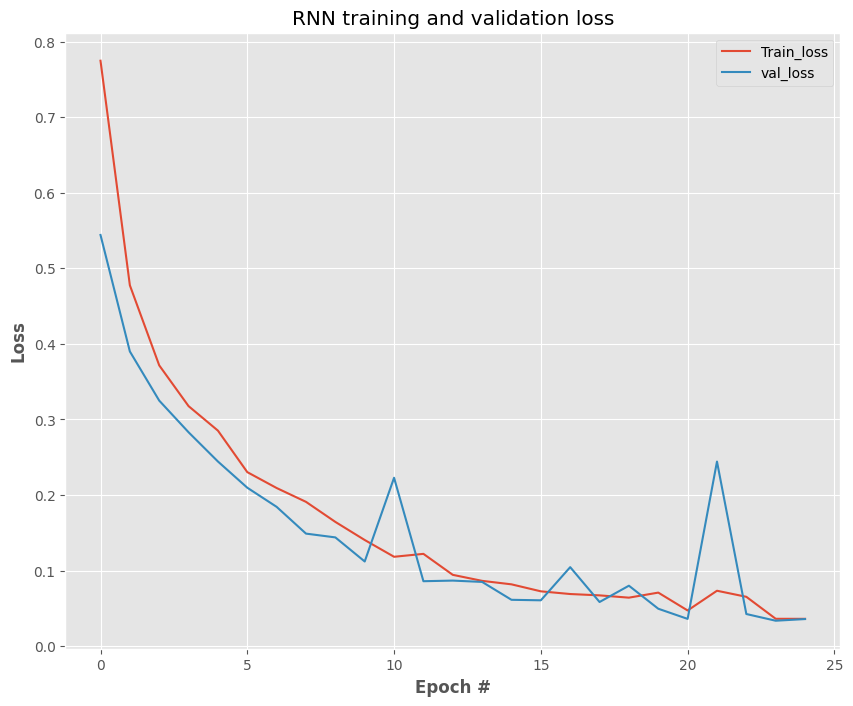

In [45]:
N = np.arange(0, epohcs)
plt.style.use('ggplot')
plt.figure(figsize=[10, 8])
plt.plot(N, results.history['loss'], label='Train_loss')
plt.plot(N, results.history['val_loss'], label='val_loss')
plt.title("RNN training and validation loss")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Loss", weight='bold')
plt.legend()
plt.show()

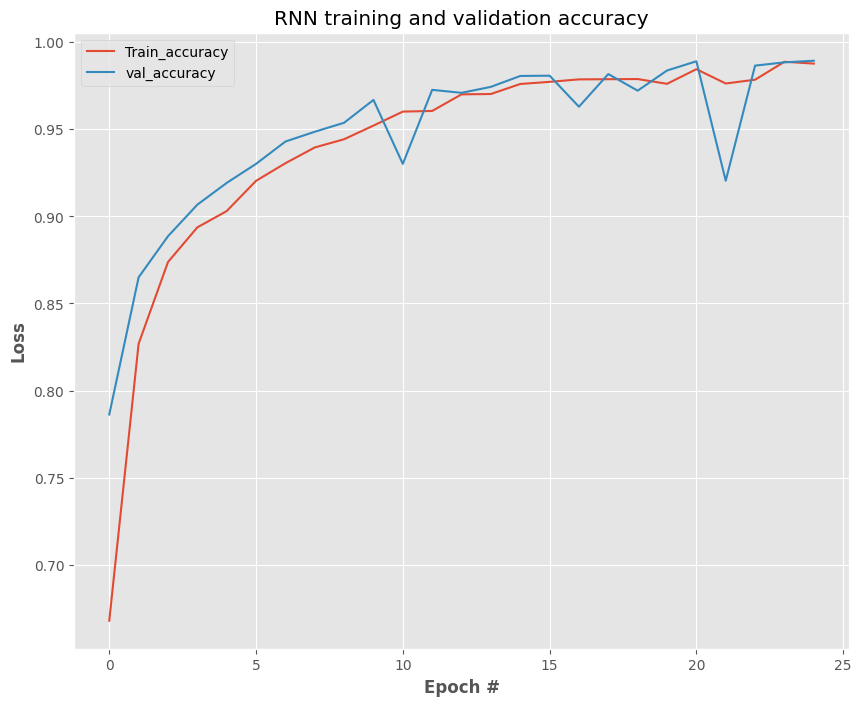

In [46]:
N = np.arange(0, epohcs)
plt.style.use('ggplot')
plt.figure(figsize=[10, 8])
plt.plot(N, results.history['accuracy'], label='Train_accuracy')
plt.plot(N, results.history['val_accuracy'], label='val_accuracy')
plt.title("RNN training and validation accuracy")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Loss", weight='bold')
plt.legend()
plt.show()

In [49]:
# Predict on a sample text

sample_text = ('The movie was good, I would recommend the movie')
predict = model.predict(np.array([sample_text]))

print(predict)

#Add final predication to dataframe
if np.argmax(predict) == 0:
    print('Neutral')
elif np.argmax(predict) == 1:
    print('Positive')
else:
    print('Negative')

1/1 [==============================] - 0s 10ms/step
[[3.4379667e-08 1.0000000e+00 1.5796685e-10]]
Positive


In [52]:
sample_text = ('worst movie, dont waste your money')
predict = model.predict(np.array([sample_text]))

print(predict)

#Add final predication to dataframe
if np.argmax(predict) == 0:
    print('Neutral')
elif np.argmax(predict) == 1:
    print('Positive')
else:
    print('Negative')

1/1 [==============================] - 0s 12ms/step
[[0.02444489 0.02125793 0.9542972 ]]
Negative


In [53]:
model.save('Sentiment_RNN.model', save_format='h5')

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.src.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x29c60dcd0>]